In [ ]:
import ee
import geopandas as gpd
from src.data import gedi_pipeline
from src.data.ee import lcms_import
from src.processing.regen import regen_analysis
from src.data.fire_perimeters import FirePerimeters, FirePerimetersDB, Fire, match_gedi_to_raster, FireRastersDB
from src.data import fire_perimeters
from src.data import gedi_raster_matching
from src.data import raster
import rasterio as rio
import matplotlib.pyplot as plt
import pandas as pd
from src.constants import DATA_PATH, USER_PATH
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns
from fastai.tabular.all import save_pickle, load_pickle
from src.data import gedi_pipeline
from src.visualization.dists import plot_pdf
from src.data import gedi_pipeline
import seaborn as sns
import numpy as np
from sklearn import metrics
sns.set_theme(style="white", palette="Set2")
palette = sns.color_palette("Set2")

import importlib
importlib.reload(regen_analysis)
importlib.reload(gedi_pipeline)
importlib.reload(gedi_raster_matching)
importlib.reload(raster)
importlib.reload(fire_perimeters)

2023-06-30 12:17:26,646 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_pipeline.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-30 12:17:26,650 DEBUG: Logger /home/jk871/fire-regen/src/data/gedi_raster_matching.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]
2023-06-30 12:17:26,653 DEBUG: Logger /home/jk871/fire-regen/src/data/fire_perimeters.py already set up. [in get_logger at /home/jk871/fire-regen/src/utils/logging_util.py:51]


<module 'src.data.fire_perimeters' from '/home/jk871/fire-regen/src/data/fire_perimeters.py'>

### Load data

In [9]:
gedi_ndvi = load_pickle(f"{DATA_PATH}/gedi_ndvi_timeseries_jun_26.pkl")

In [2]:
gedi_ndvi = load_pickle(f"{DATA_PATH}/gedi_ndvi_time_for_space_jun_28.pkl")

### Filter data

In [10]:
gedi_ndvi_pft = gedi_ndvi[gedi_ndvi.pft_class == 1]

In [11]:
gedi_ndvi = gedi_ndvi_pft.astype({'burn_year': 'int32', 'severity': 'int32'})

In [12]:
gedi_ndvi = gedi_ndvi.astype({'burn_year': 'int32', 'severity': 'category'})

In [13]:
gedi_ndvi['severity'] = gedi_ndvi.severity.cat.set_categories(["Low", "Medium", "High"], True, True)

In [14]:
gedi_ndvi = gedi_ndvi.astype({'time_since_burn': 'int32'})

### Calculate relative NDVI

In [15]:
# Raw value should be df[-1] - df[1]
gedi_ndvi['ndvi_fire_loss_raw'] = gedi_ndvi["-1"] - gedi_ndvi["1"]
gedi_ndvi['ndvi_fire_loss_rel'] = (gedi_ndvi["-1"] - gedi_ndvi["1"]) / gedi_ndvi["-1"]

In [16]:
for i in range(1, 35):
    gedi_ndvi[f'{i}_rel'] = gedi_ndvi[f"{i}"] / gedi_ndvi["-1"]

### Calculate NDVI stats

In [63]:
print(gedi_ndvi['1_rel'].mean())
print(gedi_ndvi['5_rel'].mean())
print(gedi_ndvi['10_rel'].mean())
print(gedi_ndvi['15_rel'].mean())
print(gedi_ndvi['20_rel'].mean())
print(gedi_ndvi['25_rel'].mean())
print(gedi_ndvi['30_rel'].mean())
print(gedi_ndvi['32_rel'].mean())
print(gedi_ndvi.groupby("severity").median(numeric_only=True)[['1_rel', '5_rel', '10_rel', '15_rel', '20_rel', '25_rel', '30_rel', '32_rel']])
print(gedi_ndvi.groupby("severity").std(numeric_only=True)[['1_rel', '5_rel', '10_rel', '15_rel', '20_rel', '25_rel', '30_rel', '32_rel']])
print(gedi_ndvi.groupby("severity").count()[['1_rel', '5_rel', '10_rel', '15_rel', '20_rel', '25_rel', '30_rel', '32_rel']])
print(gedi_ndvi.count()[['1_rel', '5_rel', '10_rel', '15_rel', '20_rel', '25_rel', '30_rel', '31_rel', '32_rel', '33_rel', '34_rel']])

0.5808521635149536
0.7482280118050673
0.8498383302106916
0.9089497519960298
0.9781521865576622
1.0459253630646663
1.0710740673856531
1.080914339941909
             1_rel     5_rel    10_rel    15_rel    20_rel    25_rel  \
severity                                                               
Low       0.817203  0.887308  0.940685  0.977431  1.023157  1.053435   
Medium    0.574009  0.770637  0.882031  0.941063  0.991457  1.052008   
High      0.376146  0.678870  0.798230  0.885547  0.971754  1.052415   

            30_rel    32_rel  
severity                      
Low       1.068121  1.077365  
Medium    1.072314  1.088623  
High      1.092355  1.103271  
             1_rel     5_rel    10_rel    15_rel    20_rel    25_rel  \
severity                                                               
Low       0.119669  0.120999  0.114961  0.128733  0.123706  0.155678   
Medium    0.120121  0.156494  0.139426  0.147794  0.142112  0.156539   
High      0.100248  0.184308  0.171446  0.140

In [61]:
print("% of shots that did not recover fully by the year mark 32:")
print(gedi_ndvi[gedi_ndvi["32_rel"] < 1].count()["32_rel"] / gedi_ndvi.count()["32_rel"])

def get_severity(df, sev):
    return df[df.severity == sev]

low = get_severity(gedi_ndvi, "Low")
medium = get_severity(gedi_ndvi, "Medium")
high = get_severity(gedi_ndvi, "High")

print("% of shots that did not recover fully by the year mark 32:")
print(gedi_ndvi[gedi_ndvi["32_rel"] < 1].count()["32_rel"] / gedi_ndvi.count()["32_rel"])
print(low[low["32_rel"] < 1].count()["32_rel"] / low.count()["32_rel"])
print(medium[medium["32_rel"] < 1].count()["32_rel"] / medium.count()["32_rel"])
print(high[high["32_rel"] < 1].count()["32_rel"] / high.count()["32_rel"])

% of shots that did not recover fully by the year mark 32:
0.20034132225272686
% of shots that did not recover fully by the year mark 32:
0.20034132225272686
0.18744752308984047
0.2446786090621707
0.16280241935483872


In [62]:
print("% of shots that did not recover fully by the year mark 32:")
for year in range(1, 35):
    print(gedi_ndvi[gedi_ndvi[f"{year}_rel"] < 1].count()[f"{year}_rel"] / gedi_ndvi.count()[f"{year}_rel"])

% of shots that did not recover fully by the year mark 32:
0.9960186263096624
0.9917194728453136
0.9805933323942766
0.966561731657437
0.9598992307811683
0.9331740093792971
0.9280597056450491
0.8841443535106125
0.8806713389893028
0.847711934366516
0.826134558605774
0.8184002851178657
0.8034452776872079
0.7746327481189538
0.7370789304523361
0.7175569766323685
0.6806117366956986
0.5787110474338638
0.5237534075420264
0.538148071031262
0.44331114808652244
0.4628984686140874
0.3697500381815405
0.3301473654942305
0.3062043222689296
0.26402097837528393
0.25197781885397413
0.34325640167986027
0.22584622281999553
0.23288349077822762
0.21579355088602692
0.20034132225272686
0.22946175637393768
0.08829174664107485


In [140]:
palette = sns.color_palette("Paired")
palette

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

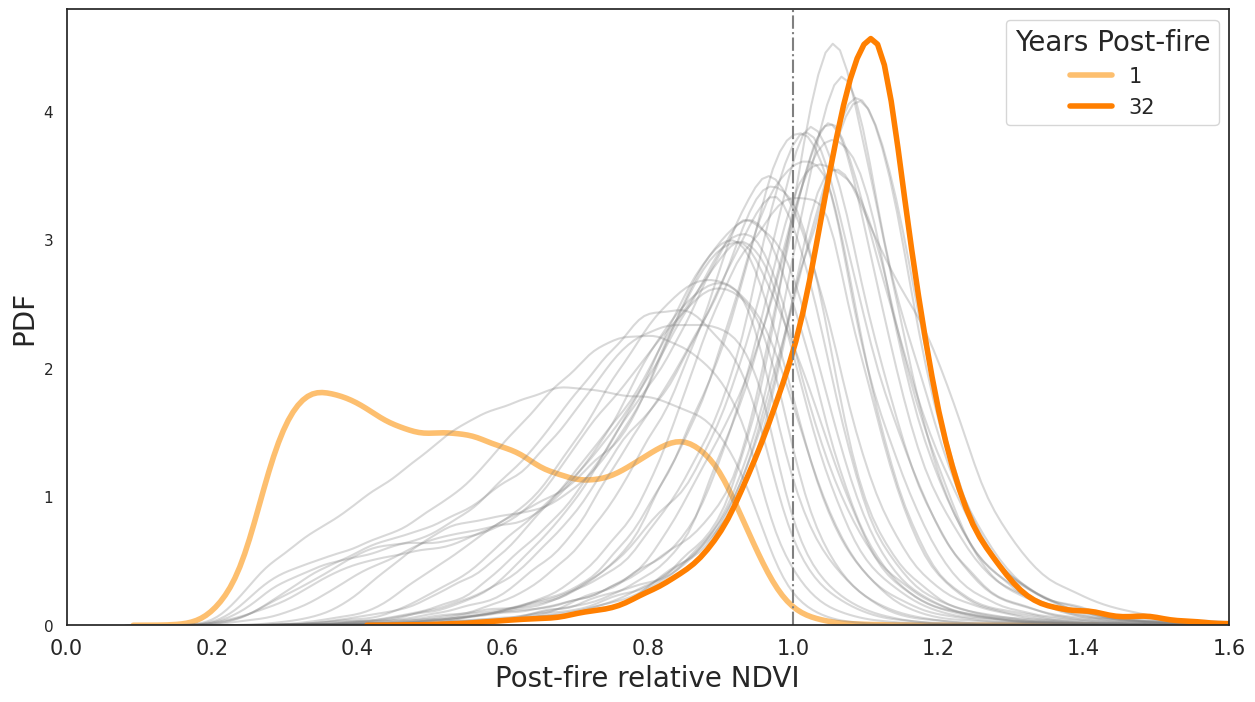

In [142]:
fig, ax = plt.subplots(1, 1, figsize=(15, 8))
sns.kdeplot(gedi_ndvi, x="1_rel", linewidth=4, label="1", legend=True, color=palette[6])
for i in range(2, 32):
    sns.kdeplot(gedi_ndvi, x=f"{i}_rel", alpha=0.3, color="gray", label='_nolegend_')
sns.kdeplot(gedi_ndvi, x="32_rel", linewidth=4, label="32", legend=True, color=palette[7])
ax.set_xlim((0, 1.6))
ax.set_xlabel("Post-fire relative NDVI", fontsize=20)
ax.set_ylabel("PDF", fontsize=20)
ax.axvline(x=1, linestyle="-.", color="gray")
plt.legend()
ax.legend(title="Years Post-fire", fontsize=15, title_fontsize=20)
ax.tick_params(axis='x', which='major', labelsize=15)

### Plot NDVI time series for different burn years 

In [3]:
temp_df = gedi_ndvi.copy()
for i in range(1, 35):
    temp_df = temp_df.drop(columns=[f"{i}"])
    temp_df = temp_df.rename(columns={f"{i}_rel": f"{i}"})

In [4]:
df_melt_rel = pd.melt(temp_df, id_vars=["severity", "burn_year"], value_vars=[str(x) for x in range(-10, 35)])
df_melt_rel = df_melt_rel.astype({'variable': 'int32'})
df_melt_rel.variable.unique()

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,
         3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,  14,  15,
        16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
        29,  30,  31,  32,  33,  34], dtype=int32)

In [5]:
df_melt = pd.melt(gedi_ndvi, id_vars=["severity", "burn_year"], value_vars=[str(x) for x in range(-10, 35)])
df_melt = df_melt.astype({'variable': 'int32'})
df_melt

,severity,burn_year,variable,value
0,Low,1985,-10,NaN
1,Low,1985,-10,NaN
2,Low,1985,-10,NaN
3,Low,1985,-10,NaN
4,Medium,1985,-10,NaN
...,...,...,...,...
14985940,Low,2020,34,NaN
14985941,Medium,2020,34,NaN
14985942,Low,2020,34,NaN
14985943,High,2020,34,NaN


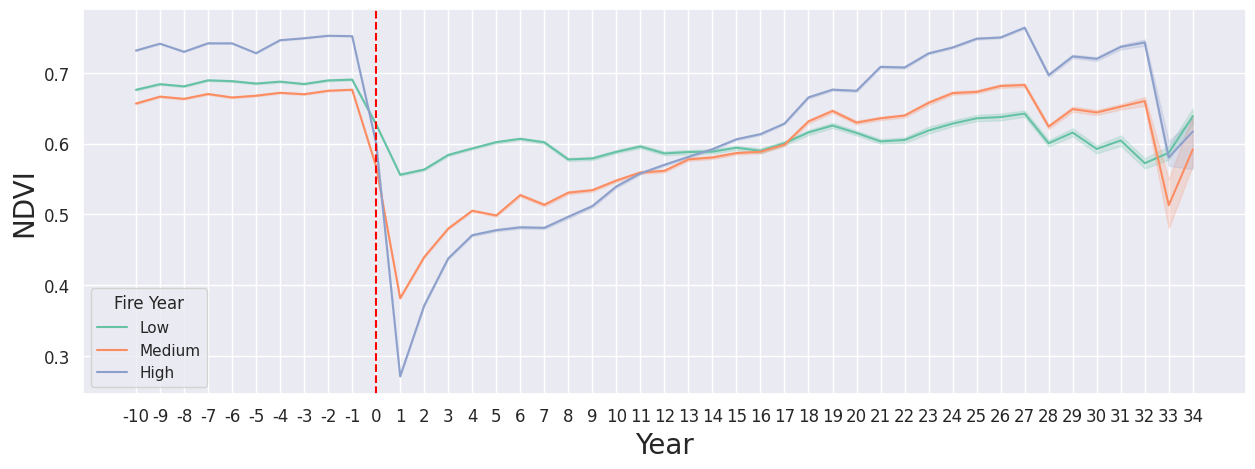

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.lineplot(df_melt, x="variable", y="value", hue="severity", ax=ax, palette="Set2", estimator="median")
ax.set_ylabel("NDVI", fontsize=20)
ax.set_xlabel("Year", fontsize=20)
ax.tick_params(axis="both", labelsize=12)
ax.axvline('0', color="red", linestyle='--')
ax.legend(title='Fire Year')

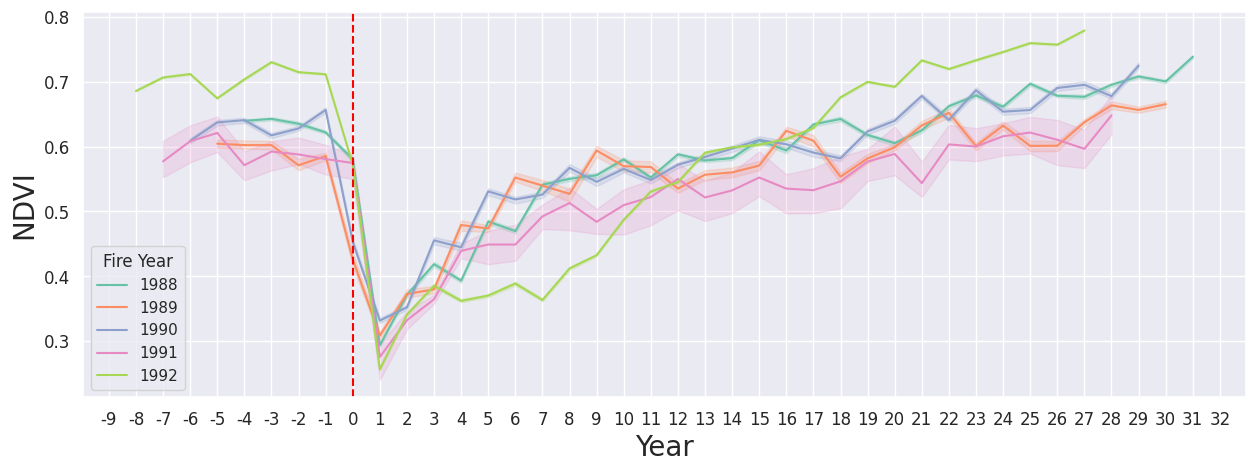

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.lineplot(df_melt[df_melt.burn_year.isin(range(1988, 1993))], x="variable", y="value", hue="burn_year", ax=ax, palette="Set2", estimator="median")
ax.set_ylabel("NDVI", fontsize=20)
ax.set_xlabel("Year", fontsize=20)
ax.tick_params(axis="both", labelsize=12)
ax.axvline('0', color="red", linestyle='--')
ax.legend(title='Fire Year')

Text(0.5, 0, '')

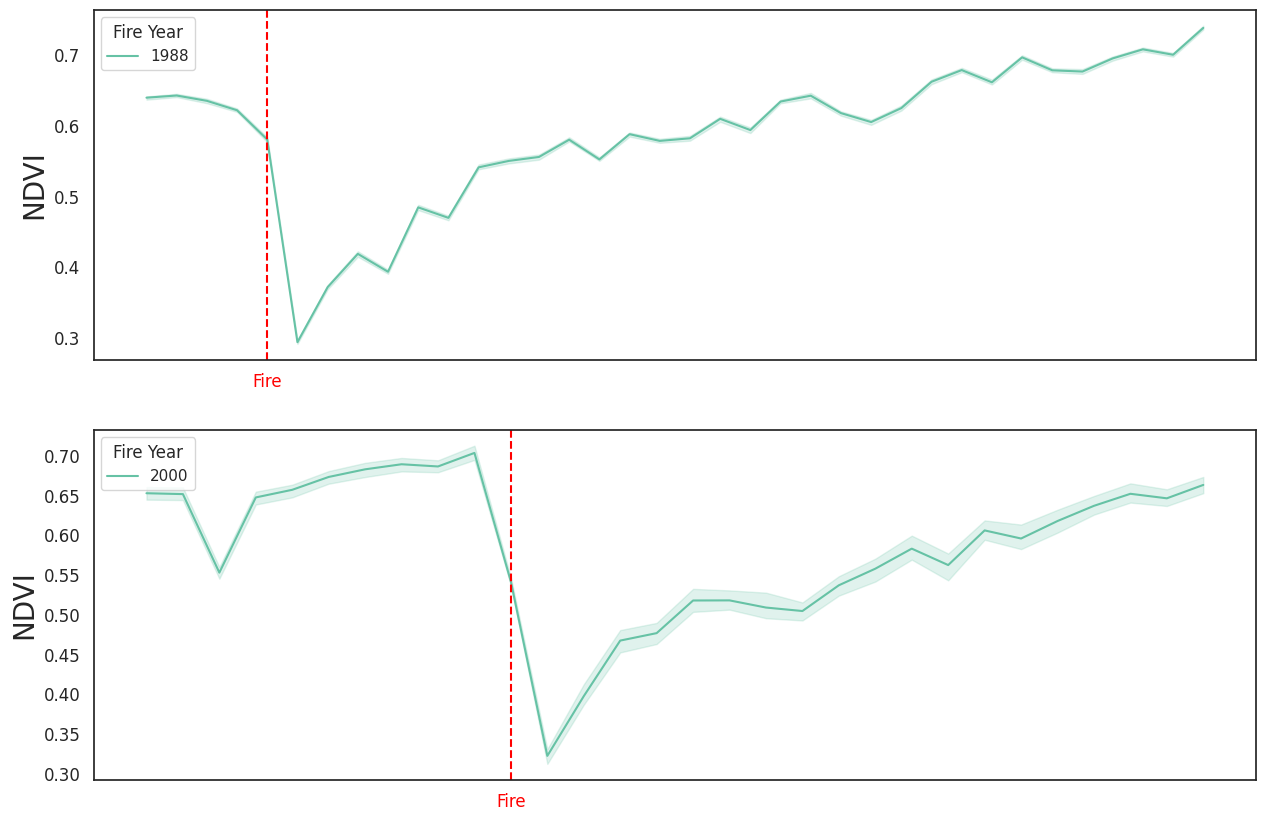

In [7]:
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sns.lineplot(df_melt[df_melt.burn_year.isin(range(1988, 1989))], x="variable", y="value", hue="burn_year", ax=ax[0], palette="Set2", estimator="median")
ax[0].set_ylabel("NDVI", fontsize=20)
ax[0].tick_params(axis="both", labelsize=12)
ax[0].axvline('0', color="red", linestyle='--')
ax[0].legend(title='Fire Year')
ax[0].set_xticks(['0'], ["Fire"], color="red")
ax[0].set_xlabel("")

sns.lineplot(df_melt[df_melt.burn_year.isin(range(2000, 2001))], x="variable", y="value", hue="burn_year", ax=ax[1], palette="Set2", estimator="median")
ax[1].set_ylabel("NDVI", fontsize=20)
ax[1].tick_params(axis="both", labelsize=12)
ax[1].axvline('0', color="red", linestyle='--')
ax[1].legend(title='Fire Year')
ax[1].set_xticks(['0'], ["Fire"], color="red")
ax[1].set_xlabel("")

Text(0.5, 0, '')

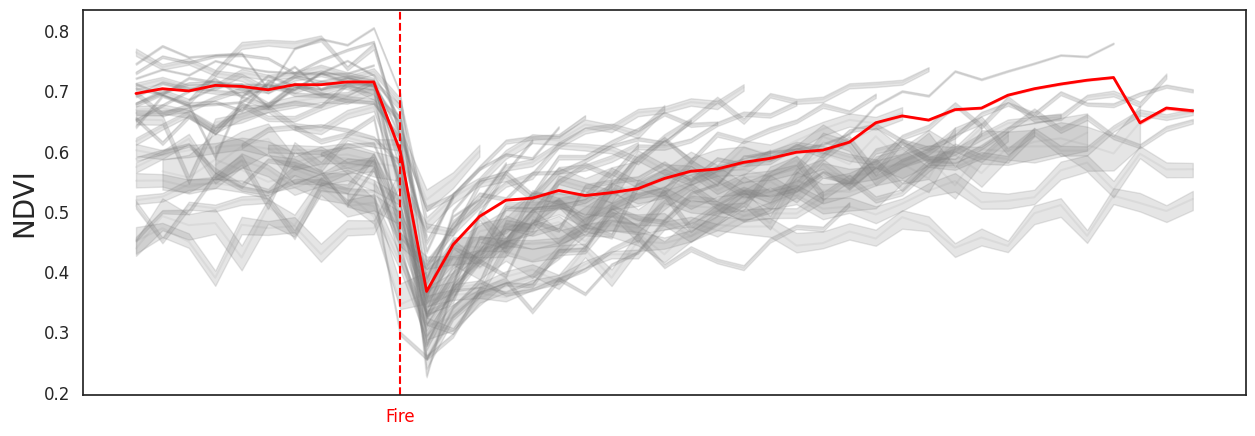

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
to_plot = df_melt[df_melt.variable <= 30]
for year in range(1984, 2021):
    sns.lineplot(to_plot[to_plot.burn_year == year], x="variable", y="value", ax=ax, color="gray", alpha=0.1, estimator="median")
sns.lineplot(to_plot, x="variable", y="value", ax=ax, color="red", estimator="median", linewidth=2)
ax.set_ylabel("NDVI", fontsize=20)
ax.tick_params(axis="both", labelsize=12)
ax.axvline('0', color="red", linestyle='--')
#ax.legend(title='Fire Year')
ax.set_xticks(['0'], ["Fire"], color="red")
ax.set_xlabel("")

# NDVI Time-Series Recovery

'\nfig.tight_layout()\n\nfig, ax = plt.subplots(1, 1, figsize=(15, 5))\n\nsns.lineplot(new_df, x="variable", y="value", hue="severity", ax=ax, palette="Set2", estimator="median")\nax.set_ylabel("Relative NDVI", fontsize=20)\nax.set_xlabel("Recovery Year", fontsize=20)\nax.tick_params(axis="both", labelsize=12)\nax.set_xticklabels(range(1, 35))\nax.legend(title=\'Fire Year\')\nax[2].axhline(y=1, linestyle="-.")\n'

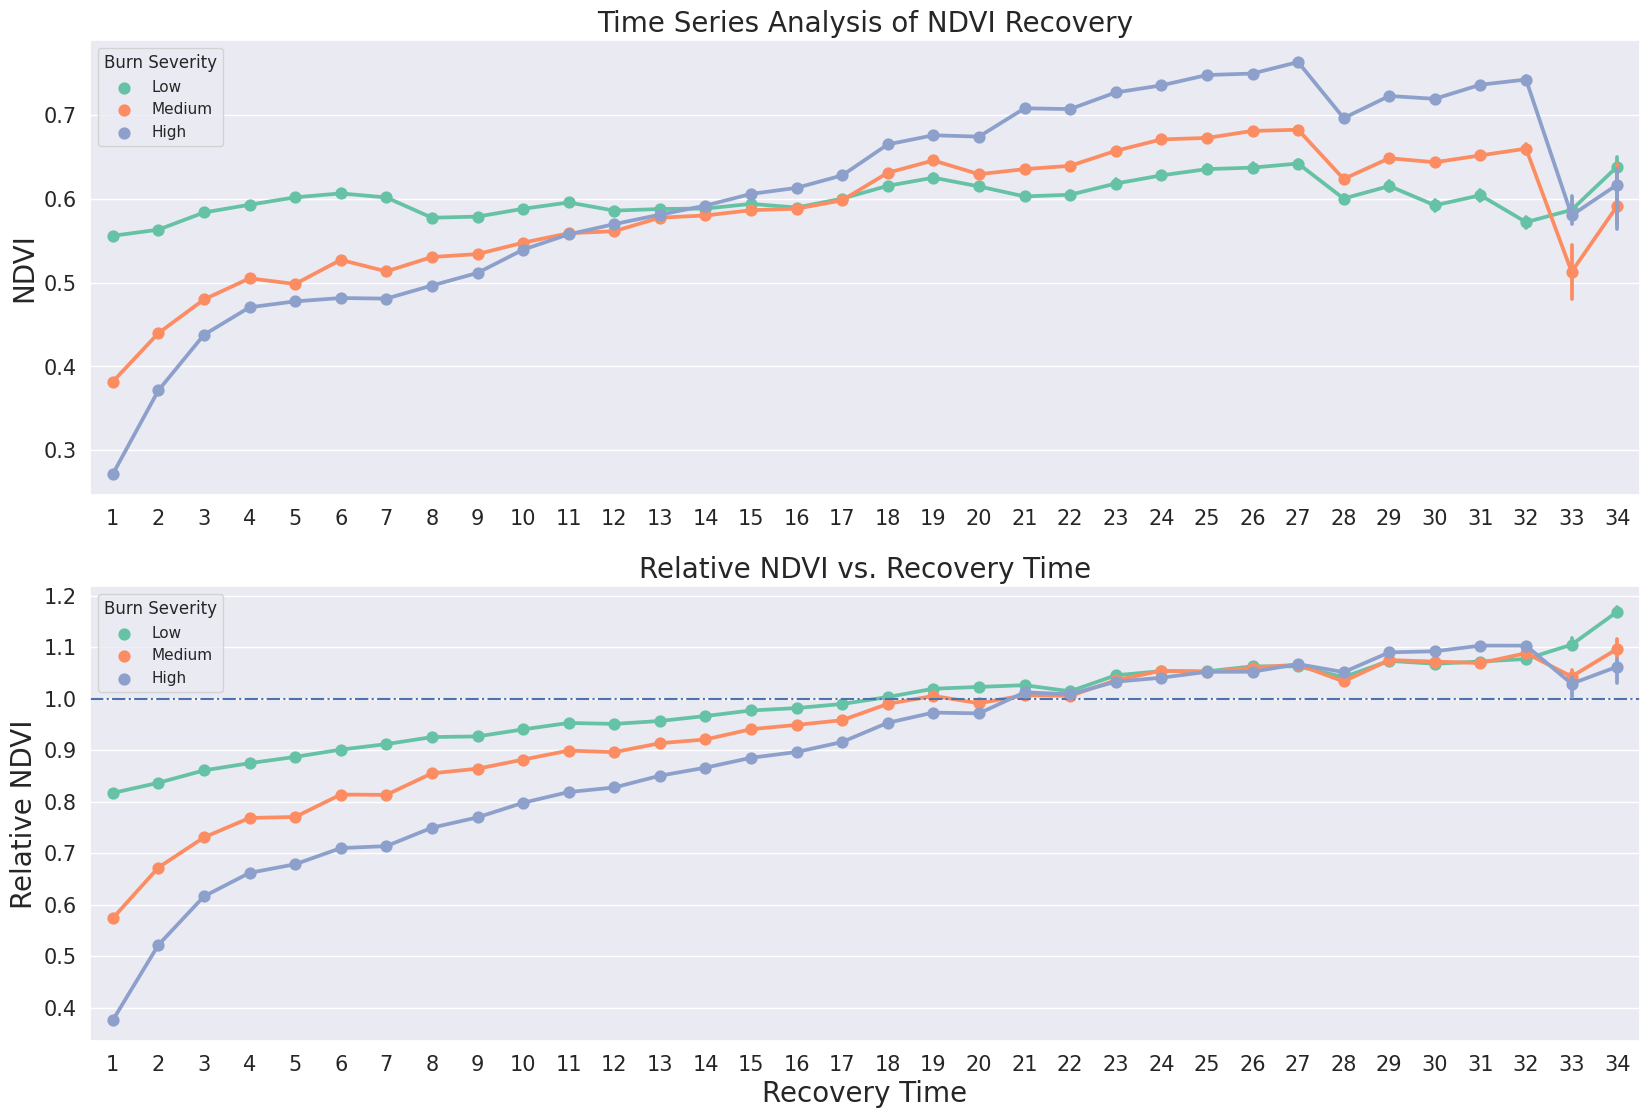

In [34]:
fig, ax = plt.subplots(2, 1, figsize=(20, 13))

sns.pointplot(df_melt[df_melt.variable > 0], x="variable", y="value", hue="severity", ax=ax[0], palette="Set2", estimator="median")
sns.pointplot(df_melt_rel, x="variable", y="value", hue="severity", ax=ax[1], palette="Set2", estimator="median")

ax[1].axhline(y=1, linestyle="-.")

ax[0].set_title("Time Series Analysis of NDVI Recovery", fontsize=20)
ax[1].set_title("Relative NDVI vs. Recovery Time", fontsize=20)

ax[0].legend(title='Burn Severity')
ax[1].legend(title='Burn Severity')
ax[0].set_xlabel("", fontsize=20)
ax[1].set_xlabel("Recovery Time", fontsize=20)
ax[0].set_xticklabels(range(1, 35))
ax[1].set_xticklabels(range(1, 35))

for i in range(2):
    ax[i].tick_params(axis='both', which='major', labelsize=15)

ax[0].set_ylabel("NDVI", fontsize=20)
ax[1].set_ylabel("Relative NDVI", fontsize=20)

# NDVI Space-for-time Recovery

In [18]:
# Fetch NDVI data from 2019 to 2022, to match the year the GEDI shots were sampled in.
for year in range(2019, 2023):
    raster = gedi_raster_matching.get_landsat_raster_sampler(int(year))
    gedi_ndvi = gedi_raster_matching.sample_raster(raster, gedi_ndvi, kernel=3)
    gedi_ndvi = gedi_ndvi.rename(columns={"NDVI_mean" : f"ndvi_{year}"})

In [20]:
gedi_ndvi

,index,shot_number,longitude,latitude,agbd,agbd_pi_lower,agbd_pi_upper,agbd_se,beam_type,sensitivity,...,33_rel,34_rel,SR_B1,SR_B2,SR_B3,SR_B4,SR_B5,SR_B6,SR_B7,NDVI
0,68024,73111100200078593,-120.746781,38.169353,188.598526,68.062080,369.264771,11.101941,full,0.987382,...,1.168298,1.264812,0.024677,0.032381,0.056981,0.057406,0.247311,0.174641,0.091033,0.622807
1,68147,225020800200125443,-120.741764,38.159710,49.447220,2.394614,156.657501,11.107099,full,0.984889,...,1.176735,1.274111,0.023223,0.029562,0.056377,0.052884,0.272358,0.171600,0.086381,0.681424
4,68278,20150200200125415,-120.747949,38.168811,167.028885,55.373684,338.802307,11.099805,coverage,0.981629,...,1.084251,1.240449,0.027842,0.036758,0.061813,0.068648,0.246424,0.186163,0.097556,0.563265
5,68394,68231100200078604,-120.747240,38.170184,43.813046,1.289604,146.474823,11.103527,full,0.973560,...,1.150200,1.256892,0.028096,0.036464,0.060046,0.068946,0.223458,0.195321,0.107513,0.526394
7,70227,42640800300287955,-120.742649,38.157309,59.594189,5.002278,174.315979,11.101964,full,0.977881,...,1.206505,1.295204,0.020000,0.027739,0.051264,0.045039,0.282322,0.167257,0.077520,0.718105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404823,27618965,225630800200085762,-119.550515,38.565973,19.979471,-9999.000000,99.098244,11.109340,full,0.965883,...,NaN,NaN,0.038721,0.046617,0.063988,0.083846,0.143704,0.181150,0.137709,0.263003
404824,27618967,225630800200085764,-119.549511,38.566621,20.807606,-9999.000000,100.928558,11.108585,full,0.968726,...,NaN,NaN,0.036002,0.041224,0.054768,0.067127,0.128743,0.159153,0.136055,0.315884
404825,27618975,225631100200080331,-119.554363,38.556271,131.316925,35.723694,287.024231,11.099050,full,0.994654,...,NaN,NaN,0.029358,0.035848,0.051284,0.060062,0.118115,0.126177,0.095985,0.329016
404826,27624050,156220200200085334,-119.406297,38.528133,31.825970,0.024733,123.779739,11.106153,coverage,0.951131,...,NaN,NaN,0.053012,0.065230,0.093980,0.124550,0.182465,0.248787,0.220103,0.189619


In [22]:
for year in range(2019, 2023):
    gedi_ndvi[f"rel_NDVI_{year}"] = gedi_ndvi[f"ndvi_{year}"] / gedi_ndvi["-1"]

In [23]:
for year in range(2019, 2023):
    gedi_ndvi.loc[gedi_ndvi['gedi_year'] == year, 'rel_NDVI'] = gedi_ndvi[gedi_ndvi['gedi_year'] == year][f"rel_NDVI_{year}"]

In [24]:
for year in range(2019, 2023):
    gedi_ndvi.loc[gedi_ndvi['gedi_year'] == year, 'NDVI_mean'] = gedi_ndvi[gedi_ndvi['gedi_year'] == year][f"ndvi_{year}"]

In [53]:
gedi_ndvi[['gedi_year', "rel_NDVI", 'rel_NDVI_2020', 'rel_NDVI_2021', 'rel_NDVI_2022', 'rel_NDVI_2019']]

,gedi_year,rel_NDVI,rel_NDVI_2020,rel_NDVI_2021,rel_NDVI_2022,rel_NDVI_2019
0,2020,1.115119,1.115119,1.133102,1.082971,1.264812
1,2022,1.118221,1.150031,1.159955,1.118221,1.274111
4,2019,1.240449,1.049214,1.092548,1.051092,1.240449
5,2020,1.099211,1.099211,1.117777,1.067332,1.256892
7,2019,1.295204,1.177124,1.216321,1.139761,1.295204
...,...,...,...,...,...,...
404823,2022,0.590146,0.791073,0.579591,0.590146,1.000000
404824,2022,0.547046,0.671420,0.439451,0.547046,1.000000
404825,2022,0.611299,0.854786,0.615183,0.611299,1.000000
404826,2021,0.384988,0.967416,0.384988,0.393366,1.000000


In [55]:
save_pickle("/maps/fire-regen/data/gedi_ndvi_time_for_space_jun_28.pkl", gedi_ndvi)

# Space-for-time vs Time Series Analysis

In [19]:
def interpolate_using_weighted_average(df, value, weight):
    result = []
    for severity in ["Low", "Medium", "High"]:
        subset = df[df.severity == severity]
        subset = subset.sort_values("time_since_burn")
        weighted_values = subset[value] * subset[weight]

        sum_of_weighted_values = weighted_values.rolling(
            window=3, center=True).sum()
        
        sum_of_weights = subset[weight].rolling(window=3, center=True).sum()
        interpolated_value = (sum_of_weighted_values / sum_of_weights).values

        interpolated_value[0] = subset[value].values[0]

        subset[f'{value}_interpolated'] = interpolated_value

        

        result.append(subset)
    return pd.concat(result)

In [20]:
def interpolate_using_weighted_average_without_severity(df, value, weight):
    subset = df.copy()
    subset = subset.sort_values("time_since_burn")
    weighted_values = subset[value] * subset[weight]

    sum_of_weighted_values = weighted_values.rolling(
        window=3, center=True).sum()
    
    sum_of_weights = subset[weight].rolling(window=3, center=True).sum()
    interpolated_value = (sum_of_weighted_values / sum_of_weights).values

    interpolated_value[0] = subset[value].values[0]

    subset[f'{value}_interpolated'] = interpolated_value
    return subset

### First, without severity - look at total NDVI

In [21]:
time_series_medians = df_melt[df_melt.variable > 0].groupby(["variable"]).median(numeric_only=True).value.reset_index().sort_values(["variable"])
time_series_medians_rel = df_melt_rel[df_melt.variable > 0].groupby(["variable"]).median(numeric_only=True).value.reset_index().sort_values(["variable"])
ndvi_medians = gedi_ndvi.groupby(["time_since_burn"]).median(numeric_only=True).NDVI_mean.reset_index().sort_values(["time_since_burn"])
ndvi_medians_rel = gedi_ndvi.groupby(["time_since_burn"]).median(numeric_only=True).rel_NDVI.reset_index().sort_values(["time_since_burn"])
ndvi_counts_rel = gedi_ndvi.groupby(["time_since_burn"]).count().rel_NDVI.reset_index()
ndvi_counts = gedi_ndvi.groupby(["time_since_burn"]).count().NDVI_mean.reset_index()
ndvi_medians["weight"] = ndvi_counts.NDVI_mean
ndvi_medians_rel["weight"] = ndvi_counts_rel.rel_NDVI
ndvi_interpolated = interpolate_using_weighted_average_without_severity(ndvi_medians, "NDVI_mean", "weight").sort_values(["time_since_burn"])
ndvi_interpolated_rel = interpolate_using_weighted_average_without_severity(ndvi_medians_rel, "rel_NDVI", "weight").sort_values(["time_since_burn"])

In [22]:
ndvi_medians = ndvi_medians[ndvi_medians.time_since_burn < 35]
ndvi_medians_rel = ndvi_medians_rel[ndvi_medians_rel.time_since_burn < 35]
ndvi_interpolated = ndvi_interpolated[ndvi_interpolated.time_since_burn < 35]
ndvi_interpolated_rel = ndvi_interpolated_rel[ndvi_interpolated_rel.time_since_burn < 35]
ndvi_interpolated

,time_since_burn,NDVI_mean,weight,NDVI_mean_interpolated
0,1,0.362125,28383,0.362125
1,2,0.467556,56674,0.441848
2,3,0.510472,11742,0.493810
3,4,0.564459,18291,0.544510
4,5,0.546677,16043,0.571465
5,6,0.592885,24548,0.579101
6,7,0.590872,15445,0.608394
7,8,0.636381,23273,0.616477
8,9,0.610971,12301,0.612301
9,10,0.548734,8559,0.597115


In [23]:
# Print reconstruction accuracies for absolute vs. relative NDVI.
print(metrics.r2_score(time_series_medians.value.values, ndvi_medians.NDVI_mean.values))
print(metrics.r2_score(time_series_medians_rel.value.values, ndvi_medians_rel.rel_NDVI.values))

0.2080483251709312
0.8356348516969563


In [24]:
# Print reconstruction accuracies for absolute vs. relative NDVI after weighted average smoothing.
print(metrics.r2_score(time_series_medians.value.values, ndvi_interpolated.NDVI_mean_interpolated.values))
print(metrics.r2_score(time_series_medians_rel.value.values, ndvi_interpolated_rel.rel_NDVI_interpolated.values))

0.4329531124850211
0.9063832826754964


In [11]:
palette

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

(0.0, 1.5)

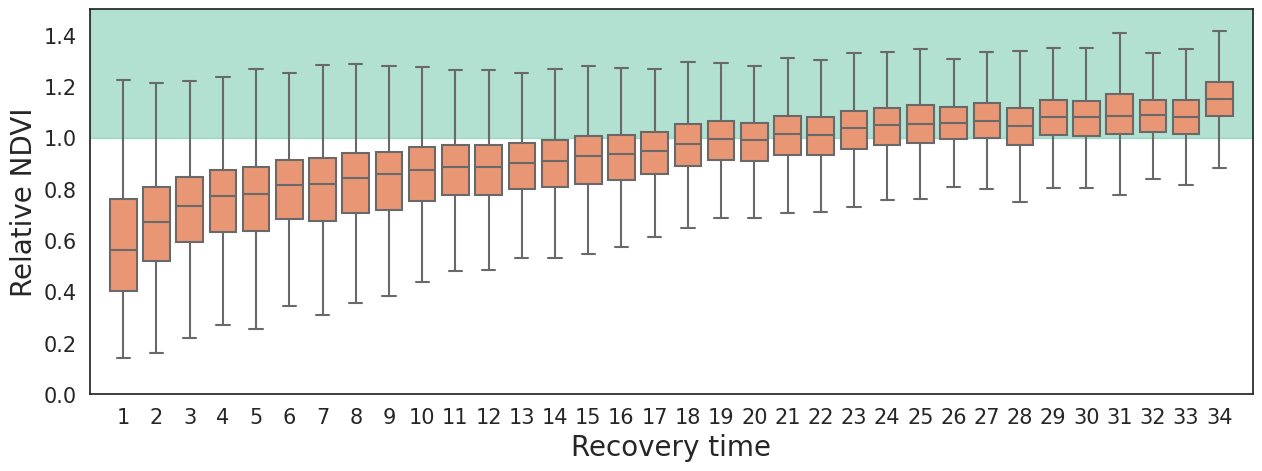

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.axhspan(1, 30, alpha=0.5, color=palette[0], zorder=-100)
sns.boxplot(df_melt_rel[df_melt_rel.variable > 0], x="variable", y="value", ax=ax, color=palette[1], showfliers=False)
ax.set_xlabel("Recovery time", fontsize=20)
ax.set_ylabel("Relative NDVI", fontsize=20)
ax.set_xlim((-1, 34))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylim((0, 1.5))

(0.0, 1.5)

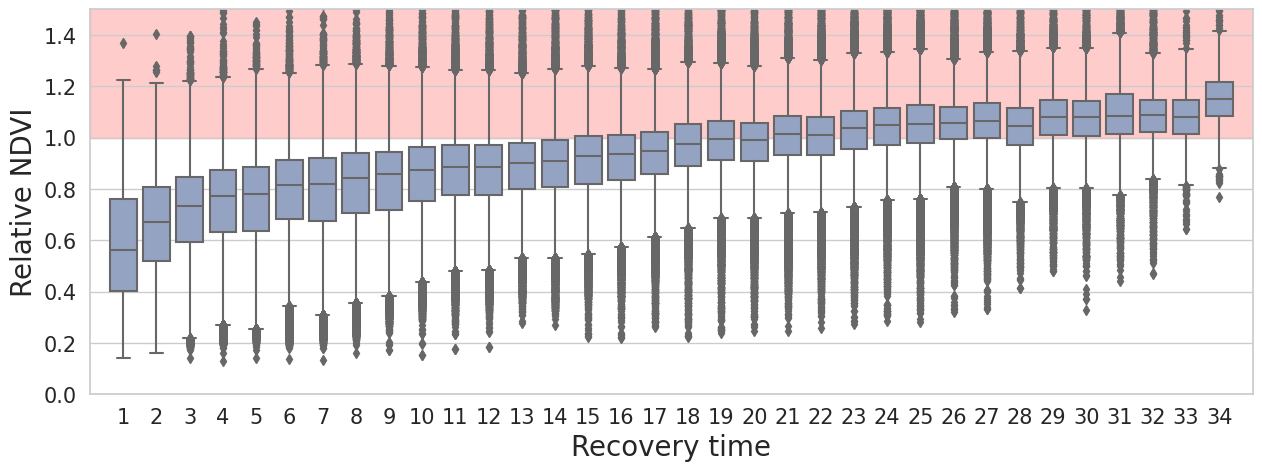

In [59]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.axhspan(1, 30, alpha=0.2, color='red', zorder=-100)
sns.boxplot(df_melt_rel[df_melt_rel.variable > 0], x="variable", y="value", ax=ax, color=palette[2], showfliers=False)
ax.set_xlabel("Recovery time", fontsize=20)
ax.set_ylabel("Relative NDVI", fontsize=20)
ax.set_xlim((-1, 34))
ax.tick_params(axis='both', which='major', labelsize=15)
ax.set_ylim((0, 1.5))

Text(0.5, 0, 'Years since fire')

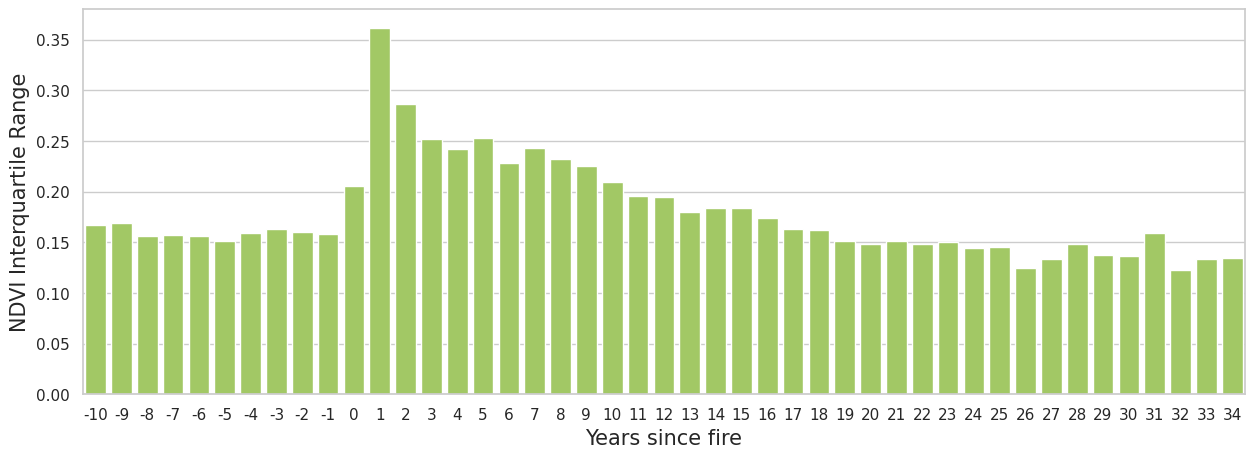

In [58]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.barplot((df_melt_rel.groupby("variable").quantile(0.75, numeric_only=True)[["value"]] - df_melt_rel.groupby("variable").quantile(0.25, numeric_only=True)[["value"]]).reset_index(), x="variable", y="value", color=palette[4], ax=ax)
ax.set_ylabel("NDVI Interquartile Range", fontsize=15)
ax.set_xlabel("Years since fire", fontsize=15)

In [60]:
# print inter-quantile ranges (IQR)
df_melt_rel.groupby("variable").quantile(0.75, numeric_only=True)[["value"]] - df_melt_rel.groupby("variable").quantile(0.25, numeric_only=True)[["value"]]

,value
variable,
-10,0.166839
-9,0.169057
-8,0.155782
-7,0.157157
-6,0.155955
-5,0.151628
-4,0.159531
-3,0.163120
-2,0.160464


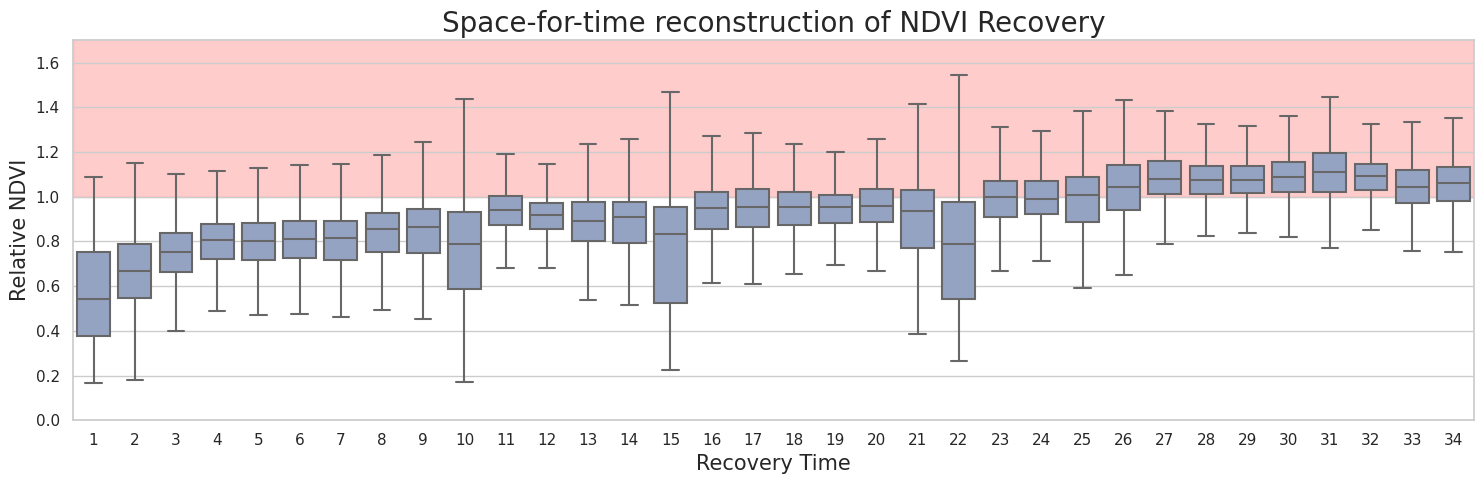

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.boxplot(gedi_ndvi[gedi_ndvi.time_since_burn < 35], x='time_since_burn', y='rel_NDVI', ax=ax, color=palette[2], showfliers=False)
ax.set_title("Space-for-time reconstruction of NDVI Recovery", fontsize=20)

ax.axhspan(1, 30, alpha=0.2, color='red', zorder=-100)

ax.set_xlabel("Recovery Time", fontsize=15)

ax.set_ylabel("Relative NDVI", fontsize=15)
ax.set_ylim((0, 1.7))
fig.tight_layout()

<Axes: xlabel='time_since_burn', ylabel='rel_NDVI'>

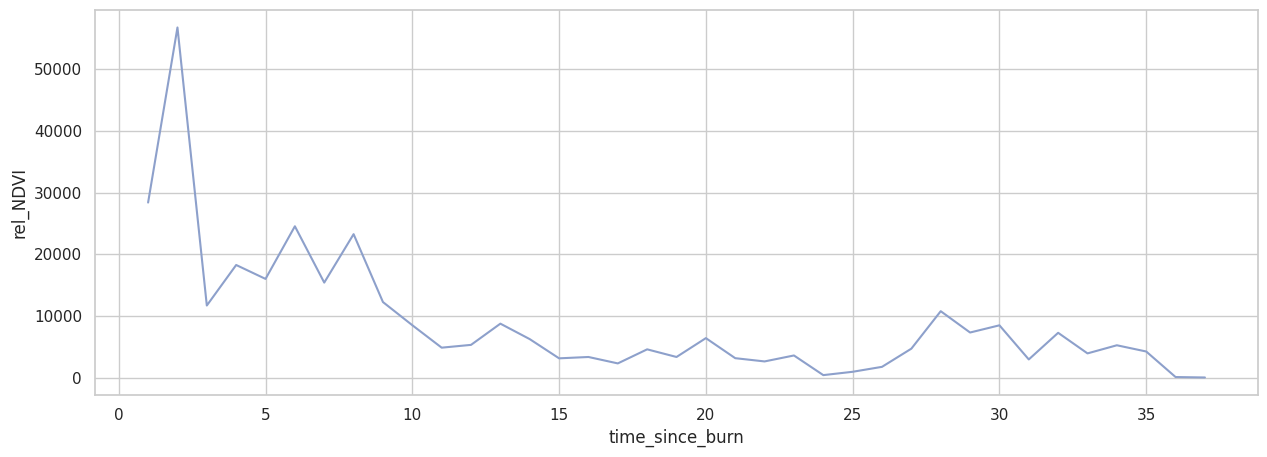

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
sns.lineplot(ndvi_counts_rel, x='time_since_burn', y='rel_NDVI', ax=ax, color=palette[2])

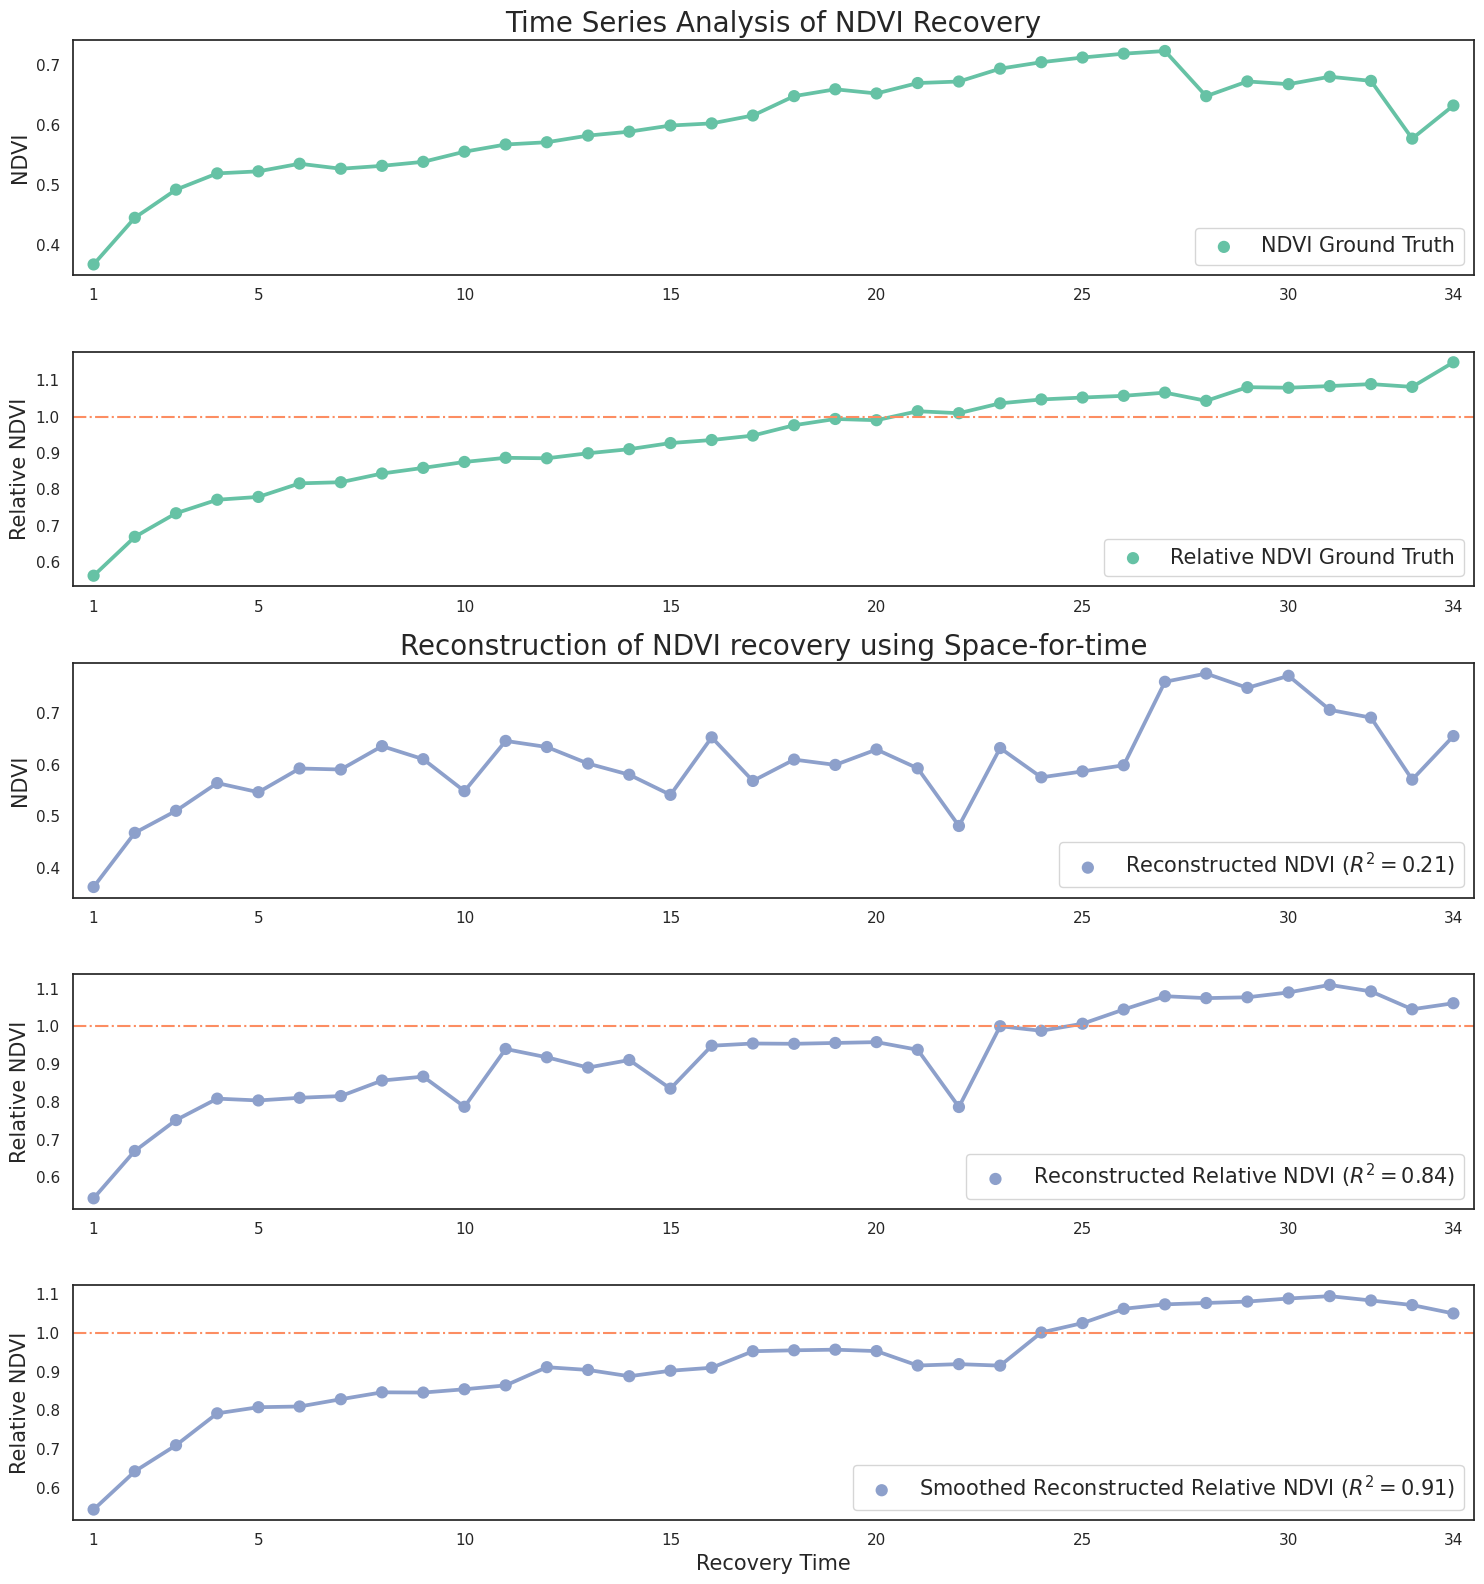

In [41]:
fig, ax = plt.subplots(5, 1, figsize=(15, 16))

sns.pointplot(time_series_medians, x="variable", y="value", ax=ax[0], estimator="median", color=palette[0], label="NDVI Ground Truth")
sns.pointplot(time_series_medians_rel, x="variable", y="value", ax=ax[1], estimator="median", color=palette[0], label="Relative NDVI Ground Truth")
ax[0].set_title("Time Series Analysis of NDVI Recovery", fontsize=20)

ax[2].set_title("Reconstruction of NDVI recovery using Space-for-time", fontsize=20)
sns.pointplot(ndvi_medians, x='time_since_burn', y='NDVI_mean', estimator='median', ax=ax[2], color=palette[2], label="Reconstructed NDVI ($R^2 = 0.21$)")
sns.pointplot(ndvi_medians_rel, x='time_since_burn', y='rel_NDVI', estimator='median', ax=ax[3], color=palette[2], label="Reconstructed Relative NDVI ($R^2 = 0.84$)")
sns.pointplot(ndvi_interpolated_rel, x='time_since_burn', y='rel_NDVI_interpolated', estimator='median', ax=ax[4], color=palette[2], label="Smoothed Reconstructed Relative NDVI ($R^2 = 0.91$)")

ax[1].set_xticklabels(range(1, 35))

ax[1].axhline(y=1, linestyle="-.", color=palette[1])
ax[3].axhline(y=1, linestyle="-.", color=palette[1])
ax[4].axhline(y=1, linestyle="-.", color=palette[1])


ax[0].set_xlabel("", fontsize=20)
ax[1].set_xlabel("", fontsize=20)
ax[2].set_xlabel("", fontsize=20)
ax[3].set_xlabel("", fontsize=20)
ax[4].set_xlabel("Recovery Time", fontsize=15)

ax[0].set_ylabel("NDVI", fontsize=15)
ax[1].set_ylabel("Relative NDVI", fontsize=15)
ax[2].set_ylabel("NDVI", fontsize=15)
ax[3].set_ylabel("Relative NDVI", fontsize=15)
ax[4].set_ylabel("Relative NDVI", fontsize=15)

ax[0].set_xticks([0, 4, 9, 14, 19, 24, 29, 33])
ax[1].set_xticks([0, 4, 9, 14, 19, 24, 29, 33])
ax[2].set_xticks([0, 4, 9, 14, 19, 24, 29, 33])
ax[3].set_xticks([0, 4, 9, 14, 19, 24, 29, 33])
ax[4].set_xticks([0, 4, 9, 14, 19, 24, 29, 33])

ax[0].legend(fontsize=15, loc="lower right")
ax[1].legend(fontsize=15, loc="lower right")
ax[2].legend(fontsize=15, loc="lower right")
ax[3].legend(fontsize=15, loc="lower right")
ax[4].legend(fontsize=15, loc="lower right")

fig.tight_layout()

# Effects of burn severity on NDVI and AGBD recovery

In [73]:
def calc_medians_and_interpolate(df, value):
    df_medians = df.groupby(["severity", "time_since_burn"]).median(numeric_only=True)[value].reset_index()
    df_counts = df.groupby(["severity", "time_since_burn"]).count()[value].reset_index()
    df_medians["weight"] = df_counts[value]
    return interpolate_using_weighted_average(df_medians, value, "weight")

agbd_interpolated = calc_medians_and_interpolate(gedi_ndvi, "rel_agbd")

In [88]:
time_series_medians = df_melt[df_melt.variable > 0].groupby(["severity", "variable"]).median(numeric_only=True).value.reset_index().sort_values(["variable", "severity"])
time_series_medians_rel = df_melt_rel[df_melt.variable > 0].groupby(["severity", "variable"]).median(numeric_only=True).value.reset_index().sort_values(["variable", "severity"])
ndvi_medians = gedi_ndvi.groupby(["severity", "time_since_burn"]).median(numeric_only=True).NDVI_mean.reset_index().sort_values(["time_since_burn", "severity"])
ndvi_medians_rel = gedi_ndvi.groupby(["severity", "time_since_burn"]).median(numeric_only=True).rel_NDVI.reset_index().sort_values(["time_since_burn", "severity"])
ndvi_counts_rel = gedi_ndvi.groupby(["severity", "time_since_burn"]).count().rel_NDVI.reset_index()
ndvi_counts = gedi_ndvi.groupby(["severity", "time_since_burn"]).count().NDVI_mean.reset_index()
ndvi_medians["weight"] = ndvi_counts.NDVI_mean
ndvi_medians_rel["weight"] = ndvi_counts_rel.rel_NDVI
ndvi_interpolated = interpolate_using_weighted_average(ndvi_medians, "NDVI_mean", "weight").sort_values(["time_since_burn", "severity"])
ndvi_interpolated_rel = interpolate_using_weighted_average(ndvi_medians_rel, "rel_NDVI", "weight").sort_values(["time_since_burn", "severity"])

In [70]:
ndvi_medians = ndvi_medians[ndvi_medians.time_since_burn < 35]
ndvi_medians_rel = ndvi_medians_rel[ndvi_medians_rel.time_since_burn < 35]
ndvi_interpolated = ndvi_interpolated[ndvi_interpolated.time_since_burn < 35]
ndvi_interpolated_rel = ndvi_interpolated_rel[ndvi_interpolated_rel.time_since_burn < 35]
ndvi_interpolated

,severity,time_since_burn,NDVI_mean,weight,NDVI_mean_interpolated
0,Low,1,0.524776,11737,0.524776
37,Medium,1,0.336630,7553,0.336630
74,High,1,0.256138,9093,0.256138
1,Low,2,0.546282,19583,0.539819
38,Medium,2,0.420390,12776,0.403620
...,...,...,...,...,...
69,Medium,33,0.555706,1387,0.628848
106,High,33,0.649763,1190,0.706101
33,Low,34,0.580815,1420,0.569618
70,Medium,34,0.619326,1624,0.609465


In [103]:
gedi_ndvi_cat_3 = gedi_pipeline.add_time_since_burn_categories_3(gedi_ndvi)

In [101]:
gedi_recovery_3 = load_pickle(f"{DATA_PATH}/gedi_recovery_3.pkl")

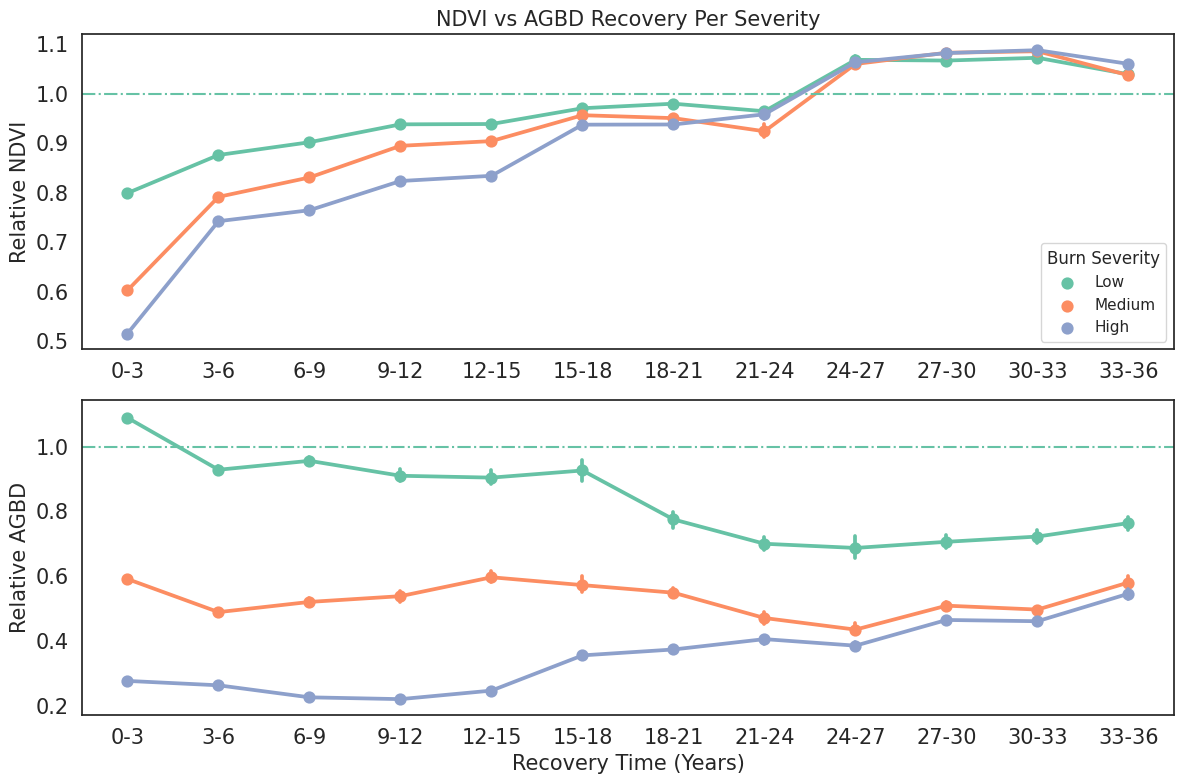

In [104]:
sns.set_theme(style="white", palette="Set2")
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

sns.pointplot(gedi_ndvi_cat_3, x='time_since_burn_cat_3', y='rel_NDVI', hue='severity', estimator='median', ax=ax[0], palette="Set2")
sns.pointplot(gedi_ndvi_cat_3, x='time_since_burn_cat_3', y='rel_agbd', hue='severity', estimator='median', ax=ax[1], palette="Set2")

ax[0].legend(title='Burn Severity')
ax[1].get_legend().remove()

ax[0].axhline(y=1, linestyle="-.")
ax[1].axhline(y=1, linestyle="-.")

ax[0].set_title("NDVI vs AGBD Recovery Per Severity", fontsize=15)


ax[0].set_xlabel("", fontsize=15)
ax[1].set_xlabel("Recovery Time (Years)", fontsize=15)

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)

ax[0].set_ylabel("Relative NDVI", fontsize=15)
ax[1].set_ylabel("Relative AGBD", fontsize=15)

ax[0].set_xticks(range(0, 12), [f"{i}-{i+3}" for i in range(0, 34, 3)])
ax[1].set_xticks(range(0, 12), [f"{i}-{i+3}" for i in range(0, 34, 3)])

fig.tight_layout()

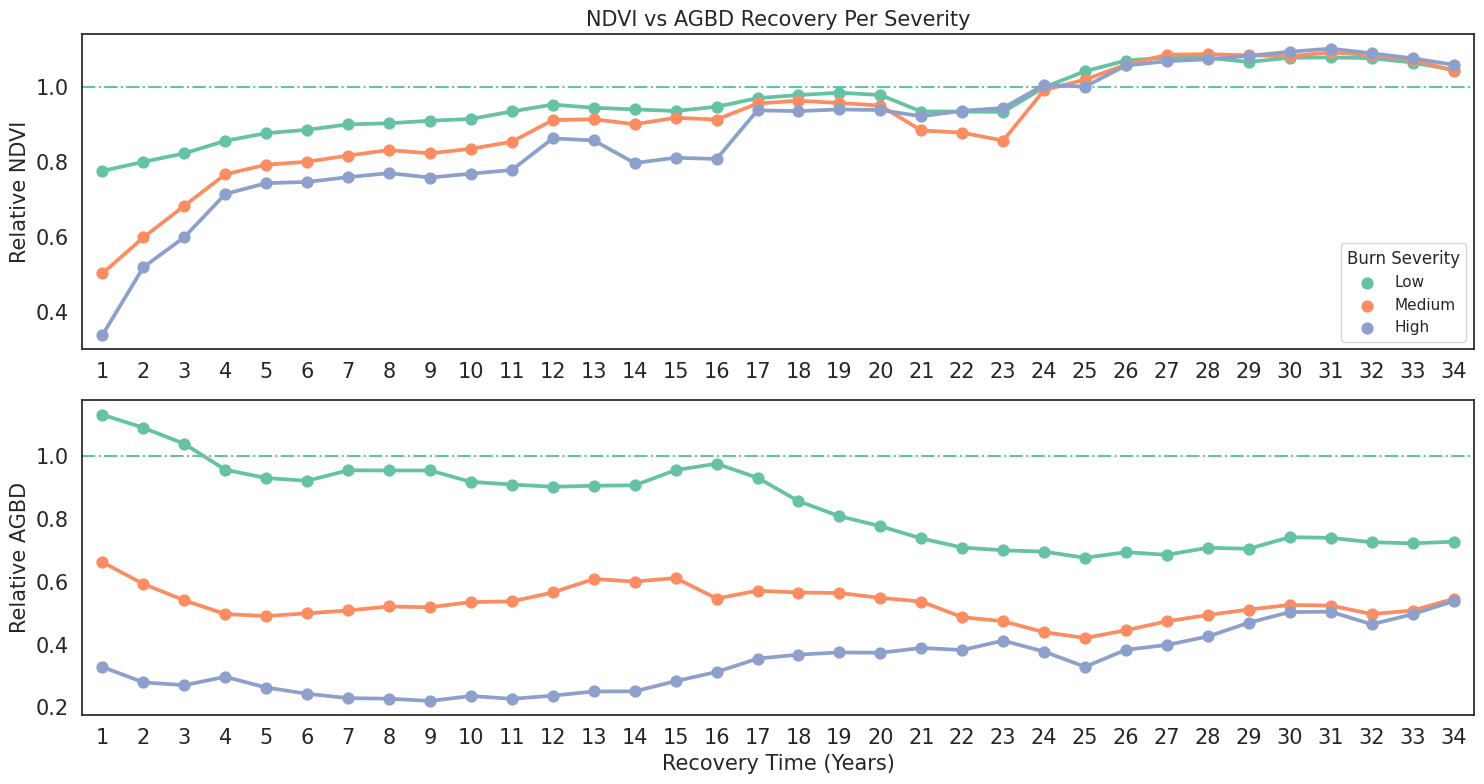

In [83]:
sns.set_theme(style="white", palette="Set2")
fig, ax = plt.subplots(2, 1, figsize=(15, 8))


sns.pointplot(ndvi_interpolated_rel, x='time_since_burn', y='rel_NDVI_interpolated', hue='severity', estimator='median', ax=ax[0], palette="Set2")
sns.pointplot(agbd_interpolated[agbd_interpolated.time_since_burn < 35], x='time_since_burn', y='rel_agbd_interpolated', hue='severity', estimator='median', ax=ax[1], palette="Set2")


ax[0].legend(title='Burn Severity')
ax[1].get_legend().remove()

ax[0].axhline(y=1, linestyle="-.")
ax[1].axhline(y=1, linestyle="-.")

ax[0].set_title("NDVI vs AGBD Recovery Per Severity", fontsize=15)


ax[0].set_xlabel("", fontsize=15)
ax[1].set_xlabel("Recovery Time (Years)", fontsize=15)

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)

ax[0].set_ylabel("Relative NDVI", fontsize=15)
ax[1].set_ylabel("Relative AGBD", fontsize=15)

#ax[2].set_xticklabels(range(1, 35))

fig.tight_layout()

In [37]:
# Interpolate metrics with weighted average.
ndvi_interpolated = interpolate_using_weighted_average(ndvi_medians, "NDVI_mean", "weight")
ndvi_interpolated_rel = interpolate_using_weighted_average(ndvi_medians_rel, "rel_NDVI", "weight")

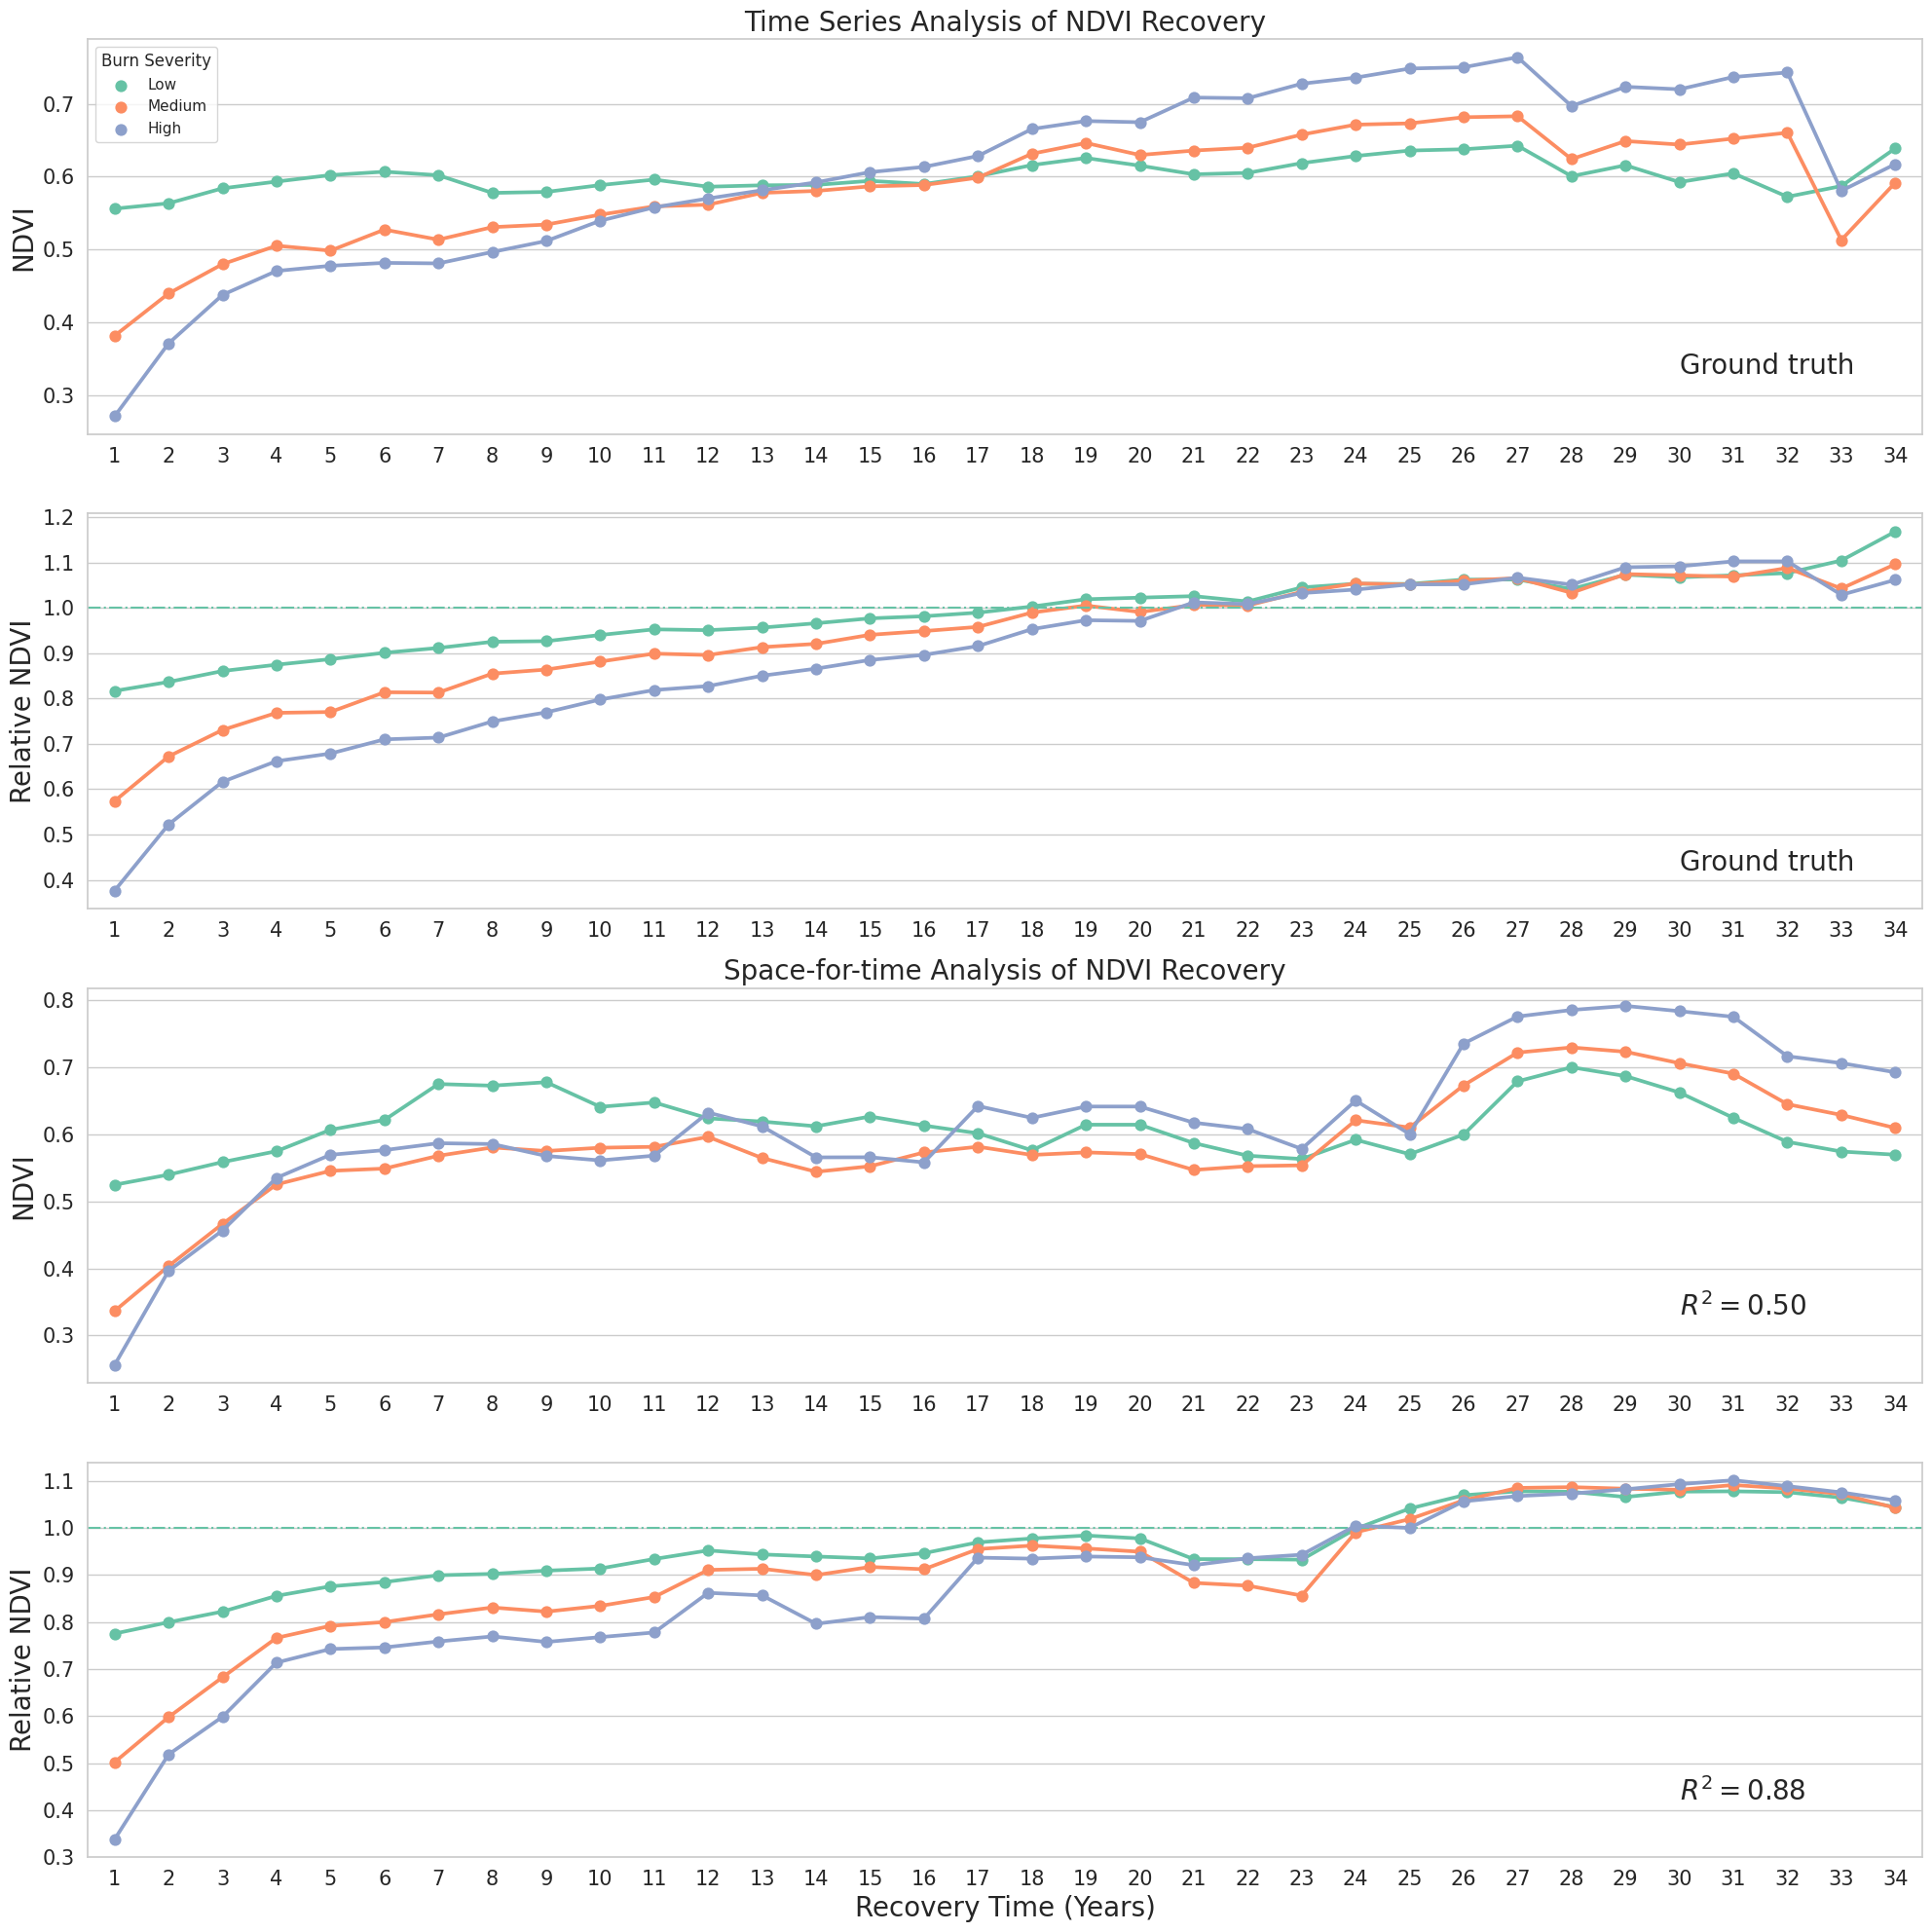

In [71]:
fig, ax = plt.subplots(4, 1, figsize=(20, 20))

sns.pointplot(time_series_medians, x="variable", y="value", hue="severity", ax=ax[0], palette="Set2", estimator="median")
sns.pointplot(time_series_medians_rel, x="variable", y="value", hue="severity", ax=ax[1], palette="Set2", estimator="median")
sns.pointplot(ndvi_interpolated, x='time_since_burn', y='NDVI_mean_interpolated', hue='severity', estimator='median', ax=ax[2], palette="Set2")
sns.pointplot(ndvi_interpolated_rel, x='time_since_burn', y='rel_NDVI_interpolated', hue='severity', estimator='median', ax=ax[3], palette="Set2")

ax[1].set_xticklabels(range(1, 35))
ax[0].legend(title='Burn Severity')
ax[1].get_legend().remove()
ax[2].get_legend().remove()
ax[3].get_legend().remove()

ax[1].axhline(y=1, linestyle="-.")
ax[3].axhline(y=1, linestyle="-.")

ax[0].set_title("Time Series Analysis of NDVI Recovery", fontsize=20)
ax[2].set_title("Space-for-time Analysis of NDVI Recovery", fontsize=20)
#ax[1].set_title("Relative NDVI vs. Recovery Time", fontsize=20)


ax[0].set_xlabel("", fontsize=20)
ax[1].set_xlabel("", fontsize=20)
ax[2].set_xlabel("", fontsize=20)
ax[3].set_xlabel("Recovery Time (Years)", fontsize=20)

ax[0].tick_params(axis='both', which='major', labelsize=15)
ax[1].tick_params(axis='both', which='major', labelsize=15)
ax[2].tick_params(axis='both', which='major', labelsize=15)
ax[3].tick_params(axis='both', which='major', labelsize=15)

ax[0].set_ylabel("NDVI", fontsize=20)
ax[1].set_ylabel("Relative NDVI", fontsize=20)
ax[2].set_ylabel("NDVI", fontsize=20)
ax[3].set_ylabel("Relative NDVI", fontsize=20)

ax[2].set_xticklabels(range(1, 35))

ax[0].text(29, 0.33, "Ground truth", fontsize=20)
ax[1].text(29, 0.42, "Ground truth", fontsize=20)
ax[2].text(29, 0.33, "$R^2 = 0.50$", fontsize=20)
ax[3].text(29, 0.42, "$R^2 = 0.88$", fontsize=20)

fig.tight_layout()